# Developing scripts for data preparation

In [1]:
import xarray as xr

from pathlib import Path
from src import utils
from src.prepare_data import prepare_dataset, _open

from dask.distributed import Client

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
from src import prepare_data

### Cluster

In [4]:
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-q express",
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83+gdata/oi10",
    ],
    local_directory="$PBS_JOBFS",
    header_skip=["select"],
)

cluster.scale(jobs=1)
client = Client(cluster)
print(f"Dask daskboard link: {client.dashboard_link}")

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Dask daskboard link: http://10.6.71.69:8787/status


In [ ]:
config_dir = (
    "/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/config/prepare_data"
)
save_dir = (
    "/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/data/processed"
)
test = prepare_dataset(
    config=f"{config_dir}/EC_Earth3.yml", save_dir=save_dir, save=False
)

In [14]:
test

[<xarray.Dataset>
 Dimensions:  (member: 10, init: 59, lead: 11, lon: 144, lat: 90)
 Coordinates:
   * member   (member) int64 1 2 3 4 5 6 7 8 9 10
   * init     (init) object 1960-11-01 00:00:00 ... 2018-11-01 00:00:00
   * lead     (lead) int64 11 23 35 47 59 71 83 95 107 119 131
     height   float64 2.0
     time     (init, lead) object dask.array<chunksize=(59, 1), meta=np.ndarray>
   * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
   * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
     area     (lat, lon) float32 dask.array<chunksize=(10, 12), meta=np.ndarray>
     zsurf    (lat, lon) float32 dask.array<chunksize=(10, 12), meta=np.ndarray>
 Data variables:
     t_ref    (init, member, lead, lat, lon) float32 dask.array<chunksize=(59, 10, 1, 10, 12), meta=np.ndarray>
 Attributes:
     regrid_method:  bilinear,
 <xarray.Dataset>
 Dimensions:  (member: 10, init: 59, lead: 11, lon: 144, lat: 90)
 Coordinates:
   * member   (me

In [17]:
import numpy as np


def get_lon_lat_average(ds, box, lon_dim="lon", lat_dim="lat"):
    """
    Return the average over a region specified by a range of longitudes and latitudes.

    Longitude is assumed to range from 0-360 deg.

    Parameters
    ----------
    ds : xarray Dataset or DataArray
        The data to subset and average. Assumed to include an "area" Variable
    box : iterable
        Iterable with the following elements in this order:
        [lon_lower, lon_upper, lat_lower, lat_upper]
    lon_dim : str, optional
        The name of the longitude dimension
    lat_dim : str, optional
        The name of the latitude dimension
    """

    def _get_lat_lon_region(ds, box, lat_dim, lon_dim):
        region = ((ds[lat_dim] >= box[2]) & (ds[lat_dim] <= box[3])) & (
            (ds[lon_dim] >= box[0]) & (ds[lon_dim] <= box[1])
        )
        return ds.where(region)

    # Force longitudues to range from 0-360
    ds = ds.assign_coords({lon_dim: (ds[lon_dim] + 360) % 360})

    if (lat_dim in ds.dims) and (lon_dim in ds.dims):
        # lat and lon are dims so use isel to get regions
        lon_inds = np.where(
            np.logical_and(ds[lon_dim].values >= box[0], ds[lon_dim].values <= box[1])
        )[0]
        lat_inds = np.where(
            np.logical_and(ds[lat_dim].values >= box[2], ds[lat_dim].values <= box[3])
        )[0]
        return (
            ds.isel({lon_dim: lon_inds, lat_dim: lat_inds})
            .weighted(ds["area"])
            .mean(dim=[lat_dim, lon_dim])
        )
    else:
        if (lat_dim in ds.dims) and (lon_dim not in ds.dims):
            average_dims = set([lat_dim, *ds[lon_dim].dims])
        elif (lat_dim not in ds.dims) and (lon_dim in ds.dims):
            average_dims = set([*ds[lat_dim].dims, lon_dim])
        else:
            average_dims = set([*ds[lat_dim].dims, *ds[lon_dim].dims])
        return (
            _get_lat_lon_region(ds, box, lat_dim, lon_dim)
            .weighted(ds["area"])
            .mean(dim=average_dims)
        )


# def get_lon_lat_box(ds, box, lon_dim="lon", lat_dim="lat"):
#     """
#     Return a region specified by a range of longitudes and latitudes.

#     Parameters
#     ----------
#     ds : xarray Dataset or DataArray
#         The data to subset
#     box : iterable
#         Iterable with the following elements in this order:
#         [lon_lower, lon_upper, lat_lower, lat_upper]
#     lon_dim : str, optional
#         The name of the longitude dimension
#     lat_dim : str, optional
#         The name of the latitude dimension
#     """
#     lon_inds = np.where(
#         np.logical_and(ds[lon_dim].values >= box[0], ds[lon_dim].values <= box[1])
#     )[0]
#     print(lon_inds)
#     lat_inds = np.where(
#         np.logical_and(ds[lat_dim].values >= box[2], ds[lat_dim].values <= box[3])
#     )[0]
#     return ds.isel({lon_dim: lon_inds, lat_dim: lat_inds})


# def get_lon_lat_average(ds, box, lon_dim="lon", lat_dim="lat"):
#     """
#     Return the average over a region specified by a range of longitudes and latitudes.

#     Parameters
#     ----------
#     ds : xarray Dataset or DataArray
#         The data to subset and average. Assumed to include an "area" Variable
#     box : iterable
#         Iterable with the following elements in this order:
#         [lon_lower, lon_upper, lat_lower, lat_upper]
#     lon_dim : str, optional
#         The name of the longitude dimension
#     lat_dim : str, optional
#         The name of the latitude dimension
#     """
#     return (
#         get_lon_lat_box(ds, box, lon_dim, lat_dim)
#         .weighted(ds["area"])
#         .mean([lon_dim, lat_dim])
#     )


def calculate_nino34(sst_anom, sst_name="sst"):
    """
    Calculate the NINO3.4 index. The NINO3.4 index is calculated as the spatial average
    of SST anomalies over the tropical Pacific region (5∘S–5∘N and 170–120∘ W).

    Parameters
    ----------
    sst_anom : xarray Dataset
        Array of sst anomalies
    sst_name : str, optional
        The name of the sst variable in sst_anom
    """

    box = [190.0, 240.0, -5.0, 5.0]
    nino34 = get_lon_lat_average(sst_anom, box)
    nino34 = nino34.rename({sst_name: "nino34"})
    nino34["nino34"].attrs = dict(long_name="ENSO Nino 3.4 Index", units="degC")
    return nino34

In [24]:
ds = test[0]

In [43]:
a = xr.open_dataset(
    "/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/data/raw/CanESM5/s2016-r1i1p2f1/Omon/tos/gn/v20190429/tos_Omon_CanESM5_dcppA-hindcast_s2016-r1i1p2f1_gn_201701-202612.nc"
)
a = xr.open_dataset(
    "/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/data/raw/CanESM5/s2016-r1i1p2f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_dcppA-hindcast_s2016-r1i1p2f1_gn_201701-202612.nc"
)
a = xr.open_dataset(
    "/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/data/raw/EC-Earth3/s2016-r1i1p1f1/Amon/tos/gr/v20201215/tos_Amon_EC-Earth3_dcppA-hindcast_s2016-r1i1p1f1_gr_201611-201710.nc"
)

In [46]:
a

<xarray.Dataset>
Dimensions:             (lead: 40, y: 291, x: 360, vertices: 4)
Coordinates:
  * lead                (lead) int64 2 5 8 11 14 17 ... 104 107 110 113 116 119
  * y                   (y) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
  * x                   (x) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    lat                 (y, x) float64 -78.39 -78.39 -78.39 ... 50.23 50.01
    lon                 (y, x) float64 73.5 74.5 75.5 76.5 ... 72.95 72.96 72.99
Dimensions without coordinates: vertices
Data variables:
    vertices_latitude   (lead, y, x, vertices) float64 -78.29 -78.49 ... 50.11
    vertices_longitude  (lead, y, x, vertices) float64 74.0 74.0 ... 72.95 73.0

In [59]:
lat_dim = "y"
lon_dim = "x"

squeeze_dims = ["init", "member", "lead"]
area = utils.gridarea_cdo(
    ds.isel({d: 0 for d in squeeze_dims if d in ds.dims}, drop=True)
)

In [62]:
b = xr.open_dataset(
    "/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/data/raw/CanESM5_hist/r1i1p2f1/Ofx/areacello/gn/v20190429/areacello_Ofx_CanESM5_historical_r1i1p2f1_gn.nc"
)["areacello"]

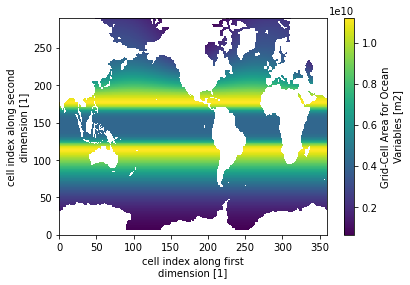

In [65]:
b.plot()

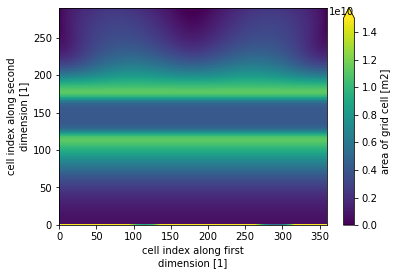

In [60]:
area.plot(vmin=0, vmax=1.5e10)

In [30]:
ds.isel({d: 0 for d in other_dims}, drop=True)

<xarray.Dataset>
Dimensions:  (y: 291, x: 360)
Coordinates:
  * y        (y) int32 0 1 2 3 4 5 6 7 8 ... 282 283 284 285 286 287 288 289 290
  * x        (x) int32 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
    lat      (y, x) float64 -78.39 -78.39 -78.39 -78.39 ... 50.51 50.23 50.01
    lon      (y, x) float64 73.5 74.5 75.5 76.5 77.5 ... 72.93 72.95 72.96 72.99
Data variables:
    sst      (y, x) float32 dask.array<chunksize=(291, 360), meta=np.ndarray>

In [23]:
utils.gridarea_cdo(test[0][["x", "y"]])

Error in calling operator gridarea with:
>>> /g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/bin/cdo -O -s -gridarea ./23c42bee97dd4e2093e22f961084472a.nc ./d5a60f04d6524a88af6f9a066455f1f0.nc<<<
STDOUT:
STDERR:Warning (cdfScanVarAttr): NetCDF: Variable not found - vertices_latitude
Warning (cdfScanVarAttr): NetCDF: Variable not found - vertices_longitude

cdo    gridarea (Abort): grid_cell_area: Unsupported grid type: generic



CDOException: (returncode:1) Warning (cdfScanVarAttr): NetCDF: Variable not found - vertices_latitude
Warning (cdfScanVarAttr): NetCDF: Variable not found - vertices_longitude

cdo    gridarea (Abort): grid_cell_area: Unsupported grid type: generic
 :: 

In [18]:
calculate_nino34(test[0])

KeyError: 'area'

In [40]:
sst_anom = xr.open_zarr("../../data/processed/CAFEf6.annual.anom_1991-2020.sst.zarr")

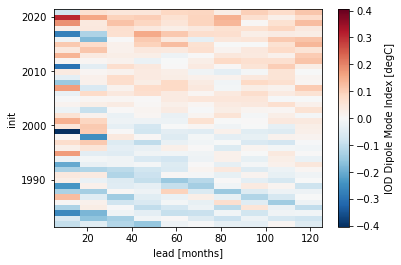

In [41]:
calculate_dmi(sst_anom)["dmi"].mean("member").plot()

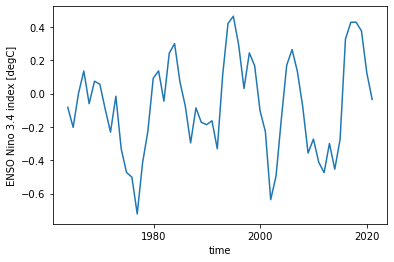

In [24]:
calculate_nino34(sst_anom)["nino34"].plot()

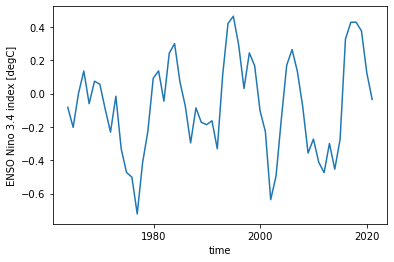

In [18]:
calculate_nino34(sst_anom)["nino34"].plot()

In [102]:
region_1 = [140, 215, 25, 45]
region_2 = [170, 270, -10, 10]
region_3 = [150, 200, -50, -15]

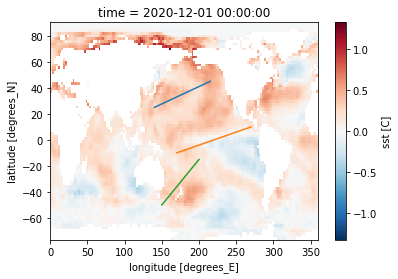

In [105]:
sst_anom["sst"].isel(time=-1).plot()
plt.plot([region_1[0], region_1[1]], [region_1[2], region_1[3]])
plt.plot([region_2[0], region_2[1]], [region_2[2], region_2[3]])
plt.plot([region_3[0], region_3[1]], [region_3[2], region_3[3]])

In [87]:
test = xr.open_zarr(f"{save_dir}/EC_Earth3.t_ref.zarr")

CPU times: user 294 ms, sys: 72.5 ms, total: 366 ms
Wall time: 1.55 s


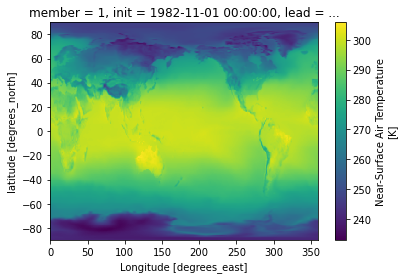

In [84]:
%%time
test["tas"].isel(member=0, init=1, lead=0).plot()

### Process some data

In [4]:
PROJECT_DIR = Path("/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/")

config_dir = PROJECT_DIR / "data/config"
save_dir = PROJECT_DIR / "data/processed"

In [5]:
%%time
prepare_dataset(config_dir / "EN422.yml", save_dir)

CPU times: user 3min 5s, sys: 35.3 s, total: 3min 41s
Wall time: 2min 28s


## Check the data

In [25]:
test = xr.open_zarr("../../data/processed/EN422.annual-Jan.anom_1991-2020.ohc300.zarr")

In [57]:
def rolling_mean(ds, window_size, start_points=None, dim="time"):
    """
    Apply a rolling mean to the data, applying 'max' to all relevant coords and optionally starting
    at a particular time point in the array

    Parameters
    ----------
    ds : xarray Dataset
        The dataset to apply the rolling mean to
    start_points : str or list of str
        Value(s) of coordinate `dim` to start the coarsening from. If these fall
        outside the range of the coordinate, coarsening starts at the beginning
        of the array
    dim : str, optional
        The name of the dimension to coarsen along
    """
    if start_points is None:
        start_points = [None]

    dss = []
    for start_point in start_points:
        rolling_mean = (
            ds.sel({dim: slice(start_point, None)})
            .rolling(
                {dim: window_size},
                min_periods=window_size,
                center=False,
            )
            .mean()
        )
        #         all_null = test_rolling.isnull().all(dim=set(test_rolling.dims) - set([dim]))
        #         dss.append(rolling_mean.where(all_null == False, drop=True))
        dss.append(test_rolling.dropna(dim=dim, how="all"))
    return xr.concat(dss, dim=dim).sortby(dim)

In [8]:
test_coarsen = utils.coarsen(
    test,
    window_size=4,
    dim="lead",
)
test_rolling = utils.rolling_mean(
    test,
    window_size=4,
    dim="lead",
)

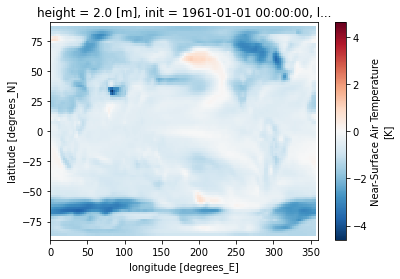

In [21]:
test_coarsen["t_ref"].isel(init=0, lead=1, member=0).plot()

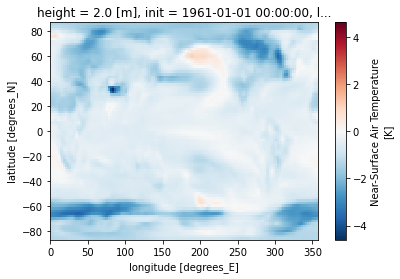

In [24]:
test_rolling["t_ref"].isel(init=0, lead=4, member=0).plot()

In [120]:
test = utils.calculate_amv(sst_anom)

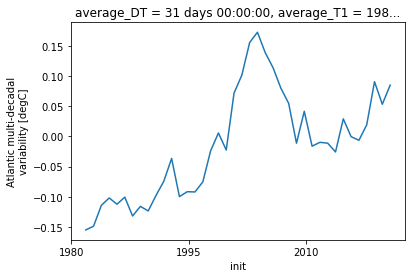

In [124]:
test["amv"].isel(lead=0).mean("member").plot()

In [296]:
ds = "CAFEf6"
var = "ohc300"
test = xr.open_zarr(PROJECT_DIR / f"data/processed/{ds}.{var}.zarr")
test

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 144, member: 40, time: 55)
Coordinates:
    area     (lat, lon) float64 dask.array<chunksize=(90, 144), meta=np.ndarray>
    height   float64 ...
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
  * time     (time) object 1960-12-01 00:00:00 ... 2014-12-01 00:00:00
Data variables:
    t_ref    (member, time, lat, lon) float32 dask.array<chunksize=(40, 55, 90, 144), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

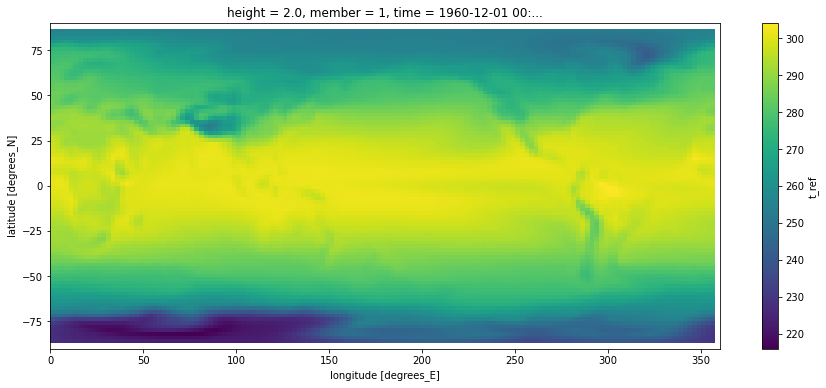

In [297]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 6))
test[var].isel(time=0, member=0).plot()

# Getting rolling working

In [1]:
import xarray as xr
from src import utils

test = xr.open_zarr("../../data/processed/CAFE60v1.annual.anom_1991-2020.t_ref.zarr")

In [6]:
def rolling_mean(ds, window_size, start_points=None, dim="time"):
    """
    Apply a rolling mean to the data, applying 'max' to all relevant coords and optionally starting
    at a particular time point in the array

    Parameters
    ----------
    ds : xarray Dataset
        The dataset to apply the rolling mean to
    start_points : str or list of str
        Value(s) of coordinate `dim` to start the coarsening from. If these fall
        outside the range of the coordinate, coarsening starts at the beginning
        of the array
    dim : str, optional
        The name of the dimension to coarsen along
    """
    if start_points is None:
        start_points = [None]

    dss = []
    for start_point in start_points:
        rolling_mean = (
            ds.sel({dim: slice(start_point, None)})
            .rolling(
                {dim: window_size},
                min_periods=window_size,
                center=False,
            )
            .mean()
        )

        return rolling_mean
#         dss.append(rolling_mean.where(rolling_mean.notnull(), drop=True))
#     return xr.concat(dss, dim=dim).sortby(dim)

In [8]:
r = rolling_mean(test, window_size=4)

In [12]:
r.where(r.notnull())

<xarray.Dataset>
Dimensions:  (time: 120, member: 96, lat: 90, lon: 144, latb: 91, lonb: 145)
Coordinates:
    area     (lat, lon) float32 dask.array<chunksize=(10, 12), meta=np.ndarray>
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * member   (member) int32 1 2 3 4 5 6 7 8 9 10 ... 88 89 90 91 92 93 94 95 96
  * time     (time) object 1960-12-01 00:00:00 ... 2020-10-01 00:00:00
    zsurf    (lat, lon) float32 dask.array<chunksize=(10, 12), meta=np.ndarray>
  * latb     (latb) float64 -90.0 -88.99 -86.97 -84.94 ... 86.97 88.99 90.0
  * lonb     (lonb) float64 0.0 2.5 5.0 7.5 10.0 ... 352.5 355.0 357.5 360.0
Data variables:
    t_ref    (time, member, lat, lon) float64 dask.array<chunksize=(120, 96, 10, 12), meta=np.ndarray>

In [22]:
import xarray as xr
from src import utils
test  = xr.open_zarr("../../data/raw/HadISST/ocean_month.zarr", use_cftime=True).isel(latitude=90, longitude=180)

In [56]:
test_annual = utils.coarsen(test, window_size=12, start_points=["1960-01-01", "1960-11-01"]).compute()
test_4year = rolling_mean(test, window_size=4*12, start_points=["1960-01-01"]).isel(time=slice(None,None,12)).compute()

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 25 times more chunks
  return self.array[key]
/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 25 times more chunks
  return self.array[key]


In [60]:
test = xr.open_zarr("../../data/processed/HadISST.annual-Jan.anom_1985-2014.sst.zarr")

In [62]:
rolling_mean(test, window_size=4)

<xarray.Dataset>
Dimensions:  (time: 58, lat: 83, lon: 144)
Coordinates:
    area     (lat, lon) float32 dask.array<chunksize=(3, 12), meta=np.ndarray>
  * lat      (lat) float64 -75.84 -73.82 -71.8 -69.78 ... 85.96 87.98 89.49
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) object 1963-12-01 00:00:00 ... 2020-12-01 00:00:00
    zsurf    (lat, lon) float32 dask.array<chunksize=(3, 12), meta=np.ndarray>
Data variables:
    sst      (time, lat, lon) float64 dask.array<chunksize=(58, 3, 12), meta=np.ndarray>

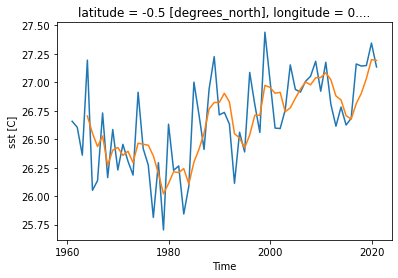

In [44]:
test_annual["sst"].plot()
test_4year["sst"].plot()

In [49]:
test_annual_anom = utils.anomalise(test_annual, ["1991-01-01", "2020-12-31"])

In [50]:
test_4annual_anom = rolling_mean(test_annual_anom, window_size=4)

In [55]:
test_4annual_anom

<xarray.Dataset>
Dimensions:    (time: 58, nv: 2)
Coordinates:
    latitude   float32 -0.5
    longitude  float32 0.5
  * time       (time) object 1963-12-16 12:00:00 ... 2020-12-16 12:00:00
Dimensions without coordinates: nv
Data variables:
    sst        (time) float32 -0.1737 -0.3251 -0.4424 ... 0.1554 0.3207 0.3141
    time_bnds  (time, nv) float32 -1.607e+04 -1.607e+04 ... 4.748e+03 4.749e+03

In [51]:
test_4year_anom = utils.anomalise(test_4year, ["1991-01-01", "2020-12-31"])

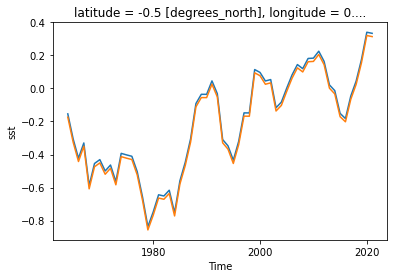

In [52]:
test_4year_anom["sst"].plot()
test_4annual_anom["sst"].plot()